In [1]:
import os

os.chdir('..')

In [2]:
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy.stats import ttest_ind

import configs
from utils.ilsvrc_utils import load_lemmas_and_wnids
from core.queries import QueryType

[nltk_data] Downloading package wordnet to /Users/alishri/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Settings

In [3]:
synsets_path = os.path.join('ilsvrc2012', 'ILSVRC2012_synsets.txt')

ival_all_path = os.path.join('ilsvrc2012', 'ILSVRC2012_val_with_sims_to_all_queries.parquet')
ival_imagename2wnid_path = os.path.join('ilsvrc2012', 'processed', 'labels', 'imagename2wnid.pkl')

sm_all_path = os.path.join('laion400m', 'subset_sm_filt_part-00000-to-part00031-5b54c5d5-bbcf-484d-a2ce-0d6f73df1a36-c000.snappy.with_sims_to_all_queries.parquet')
sm_wnid2laionindices_path = os.path.join('laion400m', 'processed', 'ilsvrc_labels', 'wnid2laionindices(substring_matched).pkl')


# Load

In [4]:
id_lemmas_df = load_lemmas_and_wnids(synsets_path)
all_wnids = id_lemmas_df[configs.ILSVRCConfigs.WNID_COL].tolist()

In [5]:
query_type = QueryType.NAME_DEF
image_to_query_sim_cols = [f'image_to_{query_type}_{wnid}_similarity' for wnid in all_wnids]

## ILSVRC val.

In [6]:
ival_df = pd.read_parquet(ival_all_path)

ival_df.tail(3)

,image_to_name_def_wnid_similarity,name_def_wnid,image_to_name_def_n02119789_similarity,image_to_name_def_n02100735_similarity,image_to_name_def_n02096294_similarity,image_to_name_def_n02066245_similarity,image_to_name_def_n02509815_similarity,image_to_name_def_n02124075_similarity,image_to_name_def_n02417914_similarity,image_to_name_def_n02123394_similarity,...,image_to_name_def_n02091032_similarity,image_to_name_def_n02102318_similarity,image_to_name_def_n02102480_similarity,image_to_name_def_n02113023_similarity,image_to_name_def_n02086646_similarity,image_to_name_def_n02091244_similarity,image_to_name_def_n02089973_similarity,image_to_name_def_n02105251_similarity,image_to_name_def_n02093754_similarity,image_to_name_def_n02112837_similarity
ILSVRC2012_val_00049998.JPEG,0.305767,border collie which is developed in the area b...,0.138302,0.246813,0.247308,0.134085,0.200509,0.168506,0.147550,0.179165,...,0.215594,0.282757,0.258892,0.240892,0.257333,0.179725,0.206783,0.218545,0.229970,0.238090
ILSVRC2012_val_00049999.JPEG,0.251934,groom which is a man participant in his own ma...,0.118232,0.132067,0.152642,0.155238,0.137646,0.136158,0.125604,0.127281,...,0.119343,0.146666,0.135072,0.176463,0.144976,0.097629,0.088823,0.096429,0.126895,0.137543
ILSVRC2012_val_00050000.JPEG,0.303315,llama which is wild or domesticated South Amer...,0.159888,0.202337,0.180610,0.136022,0.183448,0.188246,0.207823,0.171643,...,0.186493,0.166586,0.146073,0.208571,0.134718,0.162419,0.163280,0.137265,0.166315,0.195556


In [7]:
with open(ival_imagename2wnid_path, 'rb') as f:
    ival_imagename2wnid = pickle.load(f)

## Substring matched

In [8]:
sm_df = pd.read_parquet(sm_all_path)

sm_df.head(3)

,SAMPLE_ID,URL,TEXT,HEIGHT,WIDTH,LICENSE,NSFW,similarity,a_photo_of_name_def_wnid,text_to_a_photo_of_name_def_wnid_similarity,...,image_to_name_def_n02091032_similarity,image_to_name_def_n02102318_similarity,image_to_name_def_n02102480_similarity,image_to_name_def_n02113023_similarity,image_to_name_def_n02086646_similarity,image_to_name_def_n02091244_similarity,image_to_name_def_n02089973_similarity,image_to_name_def_n02105251_similarity,image_to_name_def_n02093754_similarity,image_to_name_def_n02112837_similarity
1200056513,4.745710e+11,https://t1.ftcdn.net/jpg/00/75/08/12/240_F_750...,Colorful patchwork quilt pattern,373.0,240.0,?,UNLIKELY,0.328658,a photo of quilt which is bedding made of two ...,0.805882,...,0.189664,0.176326,0.154112,0.191197,0.178234,0.183370,0.165788,0.161583,0.172031,0.159105
1200090089,1.129810e+11,https://farm6.staticflickr.com/5132/5411062185...,basket quilt top,320.0,285.0,?,UNLIKELY,0.310124,a photo of quilt which is bedding made of two ...,0.823052,...,0.178007,0.145943,0.141396,0.165080,0.152947,0.123716,0.178731,0.149959,0.165871,0.157002
1200091068,4.145784e+12,https://theplaidporticodotcom4.files.wordpress...,QuiltCon charity quilt,584.0,820.0,?,UNLIKELY,0.307640,a photo of quilt which is bedding made of two ...,0.846488,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
with open(sm_wnid2laionindices_path, 'rb') as f:
    sm_wnid2laionindices = pickle.load(f)
    
# Find the inverse map
sm_laionindex2wnid = {}
for wnid, laion_indices in sm_wnid2laionindices.items():
    for laion_index in laion_indices:
        assert laion_index not in sm_laionindex2wnid

        sm_laionindex2wnid[laion_index] = wnid

# Calc. ILSVRC val. accuracy

In [10]:
ival_image_names = [image_name for image_name in ival_imagename2wnid]

ival_sim_mat = np.array(ival_df.loc[ival_image_names, image_to_query_sim_cols].values.tolist())

print(ival_sim_mat.shape)

(50000, 999)


In [11]:
ival_wnid2top1arecorrect = {}
ival_wnid2top5arecorrect = {}

for i_i, image_name in enumerate(tqdm(ival_image_names)):
    wnid = ival_imagename2wnid[image_name]
    
    if wnid not in ival_wnid2top1arecorrect:
        ival_wnid2top1arecorrect[wnid] = []
        ival_wnid2top5arecorrect[wnid] = []
    
    if wnid not in all_wnids:
        ival_wnid2top1arecorrect[wnid].append(np.nan)
        ival_wnid2top5arecorrect[wnid].append(np.nan)
        continue
        
    true_loc = image_to_query_sim_cols.index(f'image_to_{query_type}_{wnid}_similarity')
    
    if np.isnan(ival_sim_mat[i_i, true_loc]):
        ival_wnid2top1arecorrect[wnid].append(np.nan)
        ival_wnid2top5arecorrect[wnid].append(np.nan)
        continue
    
    top_locs = np.argsort(ival_sim_mat[i_i])
    
    ival_wnid2top1arecorrect[wnid].append(true_loc == top_locs[-1])
    ival_wnid2top5arecorrect[wnid].append(true_loc in top_locs[-5:])

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:04<00:00, 11047.76it/s]


In [12]:
ival_top1_acc = np.nanmean([np.nanmean(are_correct) for _, are_correct in ival_wnid2top1arecorrect.items()])
ival_top5_acc = np.nanmean([np.nanmean(are_correct) for _, are_correct in ival_wnid2top5arecorrect.items()])

/var/folders/0x/586kgp7s0gqbff4fcbg60twm0000gq/T/ipykernel_70496/2055185247.py:1: RuntimeWarning: Mean of empty slice
  ival_top1_acc = np.nanmean([np.nanmean(are_correct) for _, are_correct in ival_wnid2top1arecorrect.items()])
/var/folders/0x/586kgp7s0gqbff4fcbg60twm0000gq/T/ipykernel_70496/2055185247.py:2: RuntimeWarning: Mean of empty slice
  ival_top5_acc = np.nanmean([np.nanmean(are_correct) for _, are_correct in ival_wnid2top5arecorrect.items()])


In [13]:
print('ival top1 acc: %.3f' % ival_top1_acc)
print('ival top5 acc: %.3f' % ival_top5_acc)

ival top1 acc: 0.569
ival top5 acc: 0.845


# Calc. substring matched accuracy

In [14]:
sm_laion_indices = [laion_index for laion_index in sm_laionindex2wnid]

sm_sim_mat = np.array(sm_df.loc[sm_laion_indices, image_to_query_sim_cols].values.tolist())

print(sm_sim_mat.shape)

(879221, 999)


In [15]:
sm_wnid2top1arecorrect = {}
sm_wnid2top5arecorrect = {}

for i_sm, laion_index in enumerate(tqdm(sm_laion_indices)):
    wnid = sm_laionindex2wnid[laion_index]
    
    if wnid not in sm_wnid2top1arecorrect:
        sm_wnid2top1arecorrect[wnid] = []
        sm_wnid2top5arecorrect[wnid] = []
    
    if wnid not in all_wnids:
        sm_wnid2top1arecorrect[wnid].append(np.nan)
        sm_wnid2top5arecorrect[wnid].append(np.nan)
        continue
        
    true_loc = image_to_query_sim_cols.index(f'image_to_{query_type}_{wnid}_similarity')
    
    if np.isnan(sm_sim_mat[i_sm, true_loc]):
        sm_wnid2top1arecorrect[wnid].append(np.nan)
        sm_wnid2top5arecorrect[wnid].append(np.nan)
        continue
    
    top_locs = np.argsort(sm_sim_mat[i_sm])
    
    sm_wnid2top1arecorrect[wnid].append(true_loc == top_locs[-1])
    sm_wnid2top5arecorrect[wnid].append(true_loc in top_locs[-5:])

100%|████████████████████████████████████████████████████████████████████████████████████████████| 879221/879221 [01:10<00:00, 12463.17it/s]


In [16]:
sm_top1_acc = np.nanmean([np.nanmean(are_correct) for _, are_correct in sm_wnid2top1arecorrect.items()])
sm_top5_acc = np.nanmean([np.nanmean(are_correct) for _, are_correct in sm_wnid2top5arecorrect.items()])

/var/folders/0x/586kgp7s0gqbff4fcbg60twm0000gq/T/ipykernel_70496/3217351014.py:1: RuntimeWarning: Mean of empty slice
  sm_top1_acc = np.nanmean([np.nanmean(are_correct) for _, are_correct in sm_wnid2top1arecorrect.items()])
/var/folders/0x/586kgp7s0gqbff4fcbg60twm0000gq/T/ipykernel_70496/3217351014.py:2: RuntimeWarning: Mean of empty slice
  sm_top5_acc = np.nanmean([np.nanmean(are_correct) for _, are_correct in sm_wnid2top5arecorrect.items()])


In [17]:
print('sm top1 acc: %.3f' % sm_top1_acc)
print('sm top5 acc: %.3f' % sm_top5_acc)

sm top1 acc: 0.665
sm top5 acc: 0.905


# Compare accs per WNID

In [18]:
def mask_nans(arr):
    if not isinstance(arr, np.ndarray):
        arr = np.array(arr)
        
    return arr[~np.isnan(arr)]

In [19]:
ival_top1_avg_accs = []
ival_top1_err_accs = []
sm_top1_avg_accs = []
sm_top1_err_accs = []
pvals1 = []

ival_top5_avg_accs = []
ival_top5_err_accs = []
sm_top5_avg_accs = []
sm_top5_err_accs = []
pvals5 = []

for wnid in all_wnids:
    if (wnid not in ival_wnid2top1arecorrect) or (wnid not in sm_wnid2top1arecorrect):
        continue
        
    ival_top1_avg_accs.append(np.nanmean(ival_wnid2top1arecorrect[wnid]))
    n = np.sum(~np.isnan(ival_wnid2top1arecorrect[wnid]))
    ival_top1_err_accs.append(1.95*np.nanstd(ival_wnid2top1arecorrect[wnid])/np.sqrt(n - 1))
    
    sm_top1_avg_accs.append(np.nanmean(sm_wnid2top1arecorrect[wnid]))
    n = np.sum(~np.isnan(sm_wnid2top1arecorrect[wnid]))
    sm_top1_err_accs.append(1.95*np.nanstd(sm_wnid2top1arecorrect[wnid])/np.sqrt(n - 1))
    
    pvals1.append(ttest_ind(
        mask_nans(ival_wnid2top1arecorrect[wnid]),
        mask_nans(sm_wnid2top1arecorrect[wnid]), 
        alternative='less').pvalue)
    
    ival_top5_avg_accs.append(np.nanmean(ival_wnid2top5arecorrect[wnid]))
    n = np.sum(~np.isnan(ival_wnid2top5arecorrect[wnid]))
    ival_top5_err_accs.append(1.95*np.nanstd(ival_wnid2top5arecorrect[wnid])/np.sqrt(n - 1))
    
    sm_top5_avg_accs.append(np.nanmean(sm_wnid2top5arecorrect[wnid]))
    n = np.sum(~np.isnan(sm_wnid2top5arecorrect[wnid]))
    sm_top5_err_accs.append(1.95*np.nanstd(sm_wnid2top5arecorrect[wnid])/np.sqrt(n - 1))
    
    pvals5.append(ttest_ind(
        mask_nans(ival_wnid2top5arecorrect[wnid]),
        mask_nans(sm_wnid2top5arecorrect[wnid]), 
        alternative='less').pvalue)
    
ival_top1_avg_accs = np.array(ival_top1_avg_accs)
ival_top1_err_accs = np.array(ival_top1_err_accs)
sm_top1_avg_accs = np.array(sm_top1_avg_accs)
sm_top1_err_accs = np.array(sm_top1_err_accs)

ival_top5_avg_accs = np.array(ival_top5_avg_accs)
ival_top5_err_accs = np.array(ival_top5_err_accs)
sm_top5_avg_accs = np.array(sm_top5_avg_accs)
sm_top5_err_accs = np.array(sm_top5_err_accs)

/var/folders/0x/586kgp7s0gqbff4fcbg60twm0000gq/T/ipykernel_70496/3335786573.py:38: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  pvals5.append(ttest_ind(
/var/folders/0x/586kgp7s0gqbff4fcbg60twm0000gq/T/ipykernel_70496/3335786573.py:23: RuntimeWarning: invalid value encountered in scalar divide
  sm_top1_err_accs.append(1.95*np.nanstd(sm_wnid2top1arecorrect[wnid])/np.sqrt(n - 1))
/Users/alishri/Desktop/Berkeley/research/hardt/projects/why imagenet looks unlike laion/codes/eval-on-laion/laionvenv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/alishri/Desktop/Berkeley/research/hardt/projects/why imagenet looks unlike laion/codes/eval-on-laion/laionvenv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning:

In [20]:
diff_top1_avg_accs = sm_top1_avg_accs - ival_top1_avg_accs
diff_top1_err_accs = np.sqrt(ival_top1_err_accs**2 + sm_top1_err_accs**2)
ucb1 = diff_top1_avg_accs + diff_top1_err_accs
lcb1 = diff_top1_avg_accs - diff_top1_err_accs

diff_top5_avg_accs = sm_top5_avg_accs - ival_top5_avg_accs
diff_top5_err_accs = np.sqrt(ival_top5_err_accs**2 + sm_top5_err_accs**2)
ucb5 = diff_top5_avg_accs + diff_top5_err_accs
lcb5 = diff_top5_avg_accs - diff_top5_err_accs

avg > 0: 0.673202614379085
UCB < 0: 94 out of 900 (0.10239651416122005)
LCB > 0: 303 out of 900 (0.3300653594771242)
6.810591097052555e-53 5.005005005005005e-05


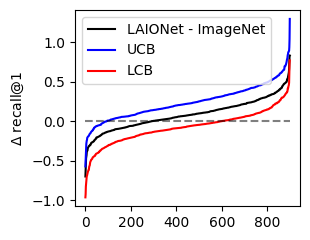

In [21]:
plt.figure(figsize=(3.2, 2.5))

mask = np.logical_and(np.logical_and(~np.isnan(diff_top1_avg_accs), ~np.isnan(ucb1)), ~np.isnan(lcb1))
x = range(np.sum(mask))

plt.plot(x, np.sort(diff_top1_avg_accs[mask]), 'k')
plt.plot(x, np.sort(ucb1[mask]), 'b')
plt.plot(x, np.sort(lcb1[mask]), 'r')

plt.plot(x, [0]*len(x), 'k--', alpha=0.5)

plt.legend(['LAIONet - ImageNet', 'UCB', 'LCB'])

plt.ylabel(r'$\Delta$ recall@1')

plt.tight_layout()

plt.savefig(os.path.join('figs', 'clip_zero_shot_recall1.pdf'))

print(f'avg > 0: {np.nanmean(diff_top1_avg_accs > 0)}')
print(f'UCB < 0: {np.sum(ucb1 < 0)} out of {np.sum(~np.isnan(ucb1))} ({np.nanmean(ucb1 < 0)})')
print(f'LCB > 0: {np.sum(lcb1 > 0)} out of {np.sum(~np.isnan(lcb1))} ({np.nanmean(lcb1 > 0)})')
print(np.nanmin(pvals1), 0.05/len(all_wnids))

avg > 0: 0.6394335511982571
UCB < 0: 122 out of 900 (0.1328976034858388)
LCB > 0: 227 out of 900 (0.24727668845315903)
4.7705466689864293e-113 5.005005005005005e-05


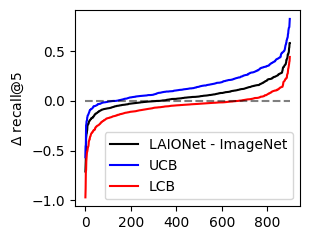

In [22]:
plt.figure(figsize=(3.2, 2.5))

mask = np.logical_and(np.logical_and(~np.isnan(diff_top5_avg_accs), ~np.isnan(ucb5)), ~np.isnan(lcb5))
x = range(np.sum(mask))

plt.plot(x, np.sort(diff_top5_avg_accs[mask]), 'k')
plt.plot(x, np.sort(ucb5[mask]), 'b')
plt.plot(x, np.sort(lcb5[mask]), 'r')

plt.plot(x, [0]*len(x), 'k--', alpha=0.5)

plt.legend(['LAIONet - ImageNet', 'UCB', 'LCB'])

plt.ylabel(r'$\Delta$ recall@5')

plt.tight_layout()

plt.savefig(os.path.join('figs', 'clip_zero_shot_recall5.pdf'))

print(f'avg > 0: {np.nanmean(diff_top5_avg_accs > 0)}')
print(f'UCB < 0: {np.sum(ucb5 < 0)} out of {np.sum(~np.isnan(ucb5))} ({np.nanmean(ucb5 < 0)})')
print(f'LCB > 0: {np.sum(lcb5 > 0)} out of {np.sum(~np.isnan(lcb5))} ({np.nanmean(lcb5 > 0)})')
print(np.nanmin(pvals5), 0.05/len(all_wnids))